## Data preprocessing (Images)

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import path

from sklearn.preprocessing import StandardScaler

PATH_IMAGE = "../data/plant-pathology-2020-fgvc7/images/"
COMMON_SIZE = (374, 640)

In [2]:
def read_image_and_transform_to_array(fileName, graySclae = True):

    print(fileName)
    pil_im = Image.open(fileName)

    # Convert to grayscale
    if graySclae:
        pil_im = pil_im.convert('L')
    # Resize to fixed size (just to make sure every image will become same size)
    pil_im = pil_im.resize((640, 374))

    return np.array(pil_im)

In [3]:
def histogram_equalization(im: np.array, num_bins = 256, reshape = True):

    imhist, bins = np.histogram( im.flatten(), num_bins, normed=True)
    cdf =imhist.cumsum()
    cds = 255 * cdf / cdf[-1]

    im_new = np.interp( im.flatten(), bins[:-1], cdf)

    if reshape:
        return im_new.reshape( im.shape ), cdf
    else:
        return im_new, cdf

In [4]:
def pca(X: np.ndarray):

    num_data, dim = X.shape

    mean_X = X.mean(axis = 0)
    X = X - mean_X

    if dim > num_data:

        M = np.dot(X, X.T)
        e, EV = np.linalg.eigh(M)
        tmp = np.dot(X.T, EV).T
        V = tmp[::-1]
        S = np.sqrt(e)[::-1]
        for i in range(1500):
            V[:, i % 50] /= S

    else:
        
        U, S, V = np.linalg.svd(X)
        V = V[:num_data]

    return V, S, mean_X

../data/plant-pathology-2020-fgvc7/images/Train_20.jpg
../data/plant-pathology-2020-fgvc7/images/Train_20.jpg


C:\Users\theho\AppData\Local\Temp\ipykernel_16064\702459257.py:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  imhist, bins = np.histogram( im.flatten(), num_bins, normed=True)


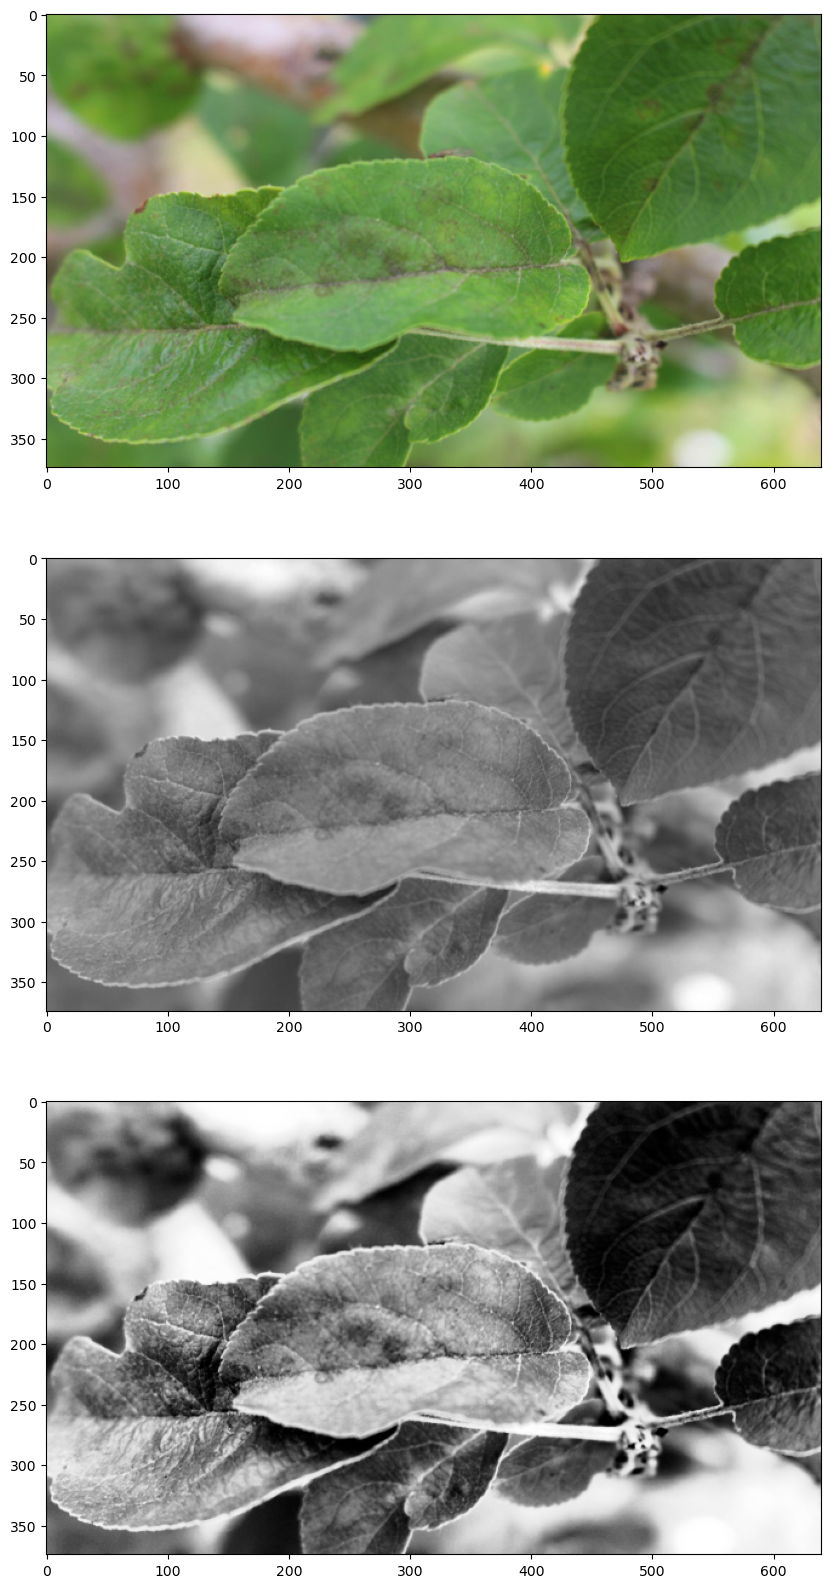

In [5]:
im = read_image_and_transform_to_array(PATH_IMAGE + "Train_20.jpg")
im_original = read_image_and_transform_to_array(PATH_IMAGE + "Train_20.jpg", False)
im_his_equal, cdf = histogram_equalization(im)

plt.figure( figsize=(50, 20))
plt.gray()
plt.subplot(3, 1, 1)
plt.imshow(im_original)
plt.subplot(3, 1, 2)
plt.imshow(im)
plt.subplot(3, 1, 3)
plt.imshow(im_his_equal)

In [6]:
# Get all name of training image, transform them to gray scale, flatten, histogram equalize and stack them together, save whole to npz file

if not path.exists("../data/plant-pathology-2020-fgvc7/images_training_preprocess.npz"):
    
    im_train_list = []
    for id in range(0, 1801):
        im_train_list.append("Train_{0}.jpg".format(id))

    immatrix = np.array([  read_image_and_transform_to_array(PATH_IMAGE + im).flatten() for im in im_train_list], 'f')
    for i in range(0, 1801):
        immatrix[i] = histogram_equalization(immatrix[i])[0]
    np.savez_compressed("../data/plant-pathology-2020-fgvc7/images_training_preprocess", immatrix)

In [7]:
immatrix = np.load("../data/plant-pathology-2020-fgvc7/images_training_preprocess.npz")["arr_0"]

In [8]:
if not path.exists("../data/plant-pathology-2020-fgvc7/images_training_PCA"):
    V, S, immean = pca(immatrix)
    np.savez_compressed("../data/plant-pathology-2020-fgvc7/images_training_PCA", V = V, S = S, immean = immean)

V = np.load("../data/plant-pathology-2020-fgvc7/images_training_PCA.npz")["V"]
S = np.load("../data/plant-pathology-2020-fgvc7/images_training_PCA.npz")["S"]
immean = np.load("../data/plant-pathology-2020-fgvc7/images_training_PCA.npz")["immean"]

V = V[:30]
immatrix = np.array([np.dot(V, f - immean) for f in immatrix])

# Standadize the features since this is required for PCA and SVM
std_scaler = StandardScaler()
Fit = std_scaler.fit(immatrix)
immatrix = Fit.transform(immatrix)

C:\Users\theho\AppData\Local\Temp\ipykernel_16064\2197393697.py:14: RuntimeWarning: invalid value encountered in sqrt
  S = np.sqrt(e)[::-1]


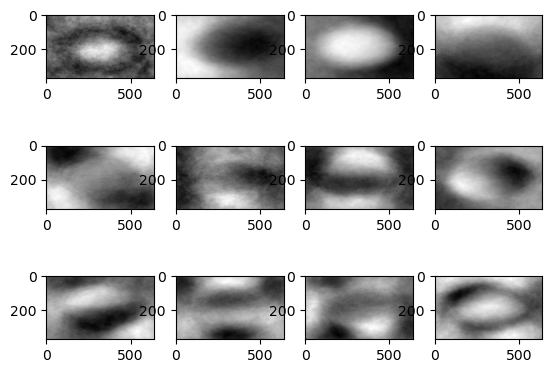

In [9]:
# Show mean and 11 "eigenleaf"

plt.figure(2)
plt.subplot(3, 4, 1)
plt.imshow(immean.reshape(374, 640))
for i in range (11):
    plt.subplot(3, 4, i + 2)
    plt.imshow(V[i].reshape(374, 640))

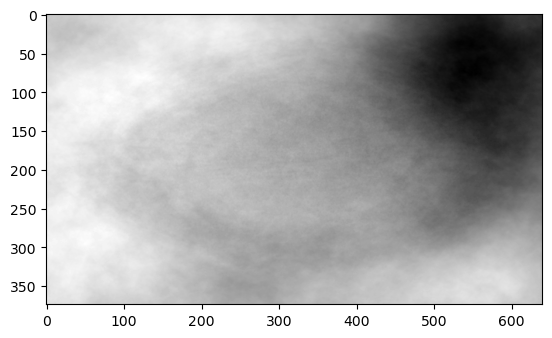

In [10]:
# Get a training picture and convert it back to original after projecting to component basis

recover = std_scaler.inverse_transform( np.array([ immatrix[20]] ))
recover = recover @ V + immean

plt.imshow(recover.reshape(COMMON_SIZE))

## Data preprocessing (Other part of training set)

In [11]:
train_csv = pd.read_csv("../data/plant-pathology-2020-fgvc7/train.csv")
train_csv['label'] = train_csv.idxmax(1, numeric_only=True)

print(train_csv)

y_train = np.array( train_csv['label'] )[:1801]

print(y_train)

        image_id  healthy  multiple_diseases  rust  scab              label
0        Train_0        0                  0     0     1               scab
1        Train_1        0                  1     0     0  multiple_diseases
2        Train_2        1                  0     0     0            healthy
3        Train_3        0                  0     1     0               rust
4        Train_4        1                  0     0     0            healthy
...          ...      ...                ...   ...   ...                ...
1816  Train_1816        0                  0     0     1               scab
1817  Train_1817        1                  0     0     0            healthy
1818  Train_1818        1                  0     0     0            healthy
1819  Train_1819        0                  0     1     0               rust
1820  Train_1820        0                  0     0     1               scab

[1821 rows x 6 columns]
['scab' 'multiple_diseases' 'healthy' ... 'rust' 'healthy' 'sca

## Training model and calculate score

In [12]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict

In [13]:
def cal_score(y_train, y_train_predict):

    precision = precision_score(y_train, y_train_predict, average="micro")
    recall = recall_score(y_train, y_train_predict, average="micro")
    f1 = f1_score(y_train, y_train_predict, average="micro")

    print("Accuray score: {0}\nRecall score: {1}\nF1 score (average micro): {2}\n".format(precision, recall, f1))

In [14]:
from sklearn.svm import LinearSVC

svm_clf = LinearSVC(C = 1, random_state = 42, dual = False)
svm_clf.fit(immatrix, y_train)
y_train_predict = cross_val_predict(svm_clf, immatrix, y_train, cv = 3)
cm = confusion_matrix(y_train, y_train_predict)
print(cm)

cal_score(y_train, y_train_predict)

[[130   0 210 169]
 [ 21   0  29  40]
 [123   0 318 176]
 [131   0 235 219]]
Accuray score: 0.37034980566352027
Recall score: 0.37034980566352027
F1 score (average micro): 0.37034980566352027



In [15]:
from sklearn.svm import SVC

rbf_kernel_svm_clf = SVC(kernel = "rbf", gamma = 0.1, C = 0.9)
rbf_kernel_svm_clf.fit(immatrix, y_train)
y_train_predict = cross_val_predict(rbf_kernel_svm_clf, immatrix, y_train, cv = 3)
cm = confusion_matrix(y_train, y_train_predict)
print(cm)

cal_score(y_train, y_train_predict)

[[ 85   0 236 188]
 [  8   0  44  38]
 [ 40   0 373 204]
 [ 32   0 285 268]]
Accuray score: 0.4031093836757357
Recall score: 0.4031093836757357
F1 score (average micro): 0.4031093836757357



## Predict on test set

In [ ]:
one_hot_lookup = {
    "healthy": 1,
    "multiple_diseases": 2,
    "rust": 3,
    "scab": 4
}

test_csv = pd.read_csv("../data/plant-pathology-2020-fgvc7/test.csv")
numpy_test_result = np.array( [ ["Test_{0}".format(i), 0, 0, 0, 0] for i in range(1821) ] )

id = 0
for i in test_csv["image_id"][0:1820]:
    test_im = read_image_and_transform_to_array(PATH_IMAGE + i + ".jpg")
    test_im = np.array( [ histogram_equalization(test_im, reshape = False)[0] ] )
    test_im = np.array([np.dot(V, f - immean) for f in test_im])
    test_im = Fit.transform(test_im)
    category = rbf_kernel_svm_clf.predict(test_im)[0]
    numpy_test_result[id][ one_hot_lookup[category] ] = 1
    id += 1

In [23]:
test_result_csv = pd.DataFrame(data = numpy_test_result[0:, 1:], index=numpy_test_result[0:, 0])
#test_result_csv.columns = ["image_id", "healthy", "multiple_diseases", "rust", "scab"]
test_result_csv.to_csv("../data/plant-pathology-2020-fgvc7/submission.csv")